In [326]:
import numpy as np
import pandas as pd
from scipy import optimize
from numpy.linalg import norm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from catboost import CatBoostRegressor, CatBoostClassifier, Pool
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import json
import warnings
import random

warnings.simplefilter('ignore')
%matplotlib inline

# Загрузка подготовленных данных

In [387]:
# Функция для загрузки подготовленных данных
def load_func(filename='data_fin.zip', colname='columns.json'):
    data = pd.read_csv(filename)
    col_data = None
    if colname is not None:
        with open(colname) as f:
            col_data = json.load(f)

    return data, col_data

# Функция для сохранения результатов расчета
def save_func(data, col_data=None, filename='data_fin.zip', colname="columns_fin.json"):
    data.to_csv(filename, index=False)
    if col_data is not None:
        with open(colname, "w") as f:
            f.write(json.dumps(col_data))
            
# Функция для выгрузки результатов в Kaggle           
def submission_to_csv(data, y_res_name = "", sub_file = "", print_head = True):
    if (y_res_name == "") or (sub_file == ""):
        print("Не удалось сохранить в файл")
        return
    
    submission = pd.DataFrame({
        "client_id": data.query('sample == 0')["client_id"],
        "default": data.query('sample == 0')[y_res_name]
    })
    
    submission.to_csv(sub_file, index=None)
    if print_head:
        print(submission.head(3))

In [328]:
data, col_data = load_func(filename='data_ini.zip', colname="columns_ini.json")
col_data_backup = col_data.copy()

# Функции для генерации TargetEncoder для различных статистик

In [313]:
def data_filtr_func(data, agg_filtr_me='', agg_filtr_val=0, sign='=='):
    if agg_filtr_me != '':
        if sign == '==':
            data_filtr = data[data[agg_filtr_me] == agg_filtr_val]
        elif sign == '!=':
            data_filtr = data[data[agg_filtr_me] != agg_filtr_val]
        elif sign == '>=':
            data_filtr = data[data[agg_filtr_me] >= agg_filtr_val]
        elif sign == '>':
            data_filtr = data[data[agg_filtr_me] > agg_filtr_val]
        elif sign == '<=':
            data_filtr = data[data[agg_filtr_me] <= agg_filtr_val]
        elif sign == '<':
            data_filtr = data[data[agg_filtr_me] < agg_filtr_val]
        else:
            data_filtr = []
    else:
        data_filtr = data

    return data_filtr


def agr_me_all(data, by='', count_me='', mean_me='', std_me='', median_me='', sum_me='',
               norm_mean=0, norm_std=0, norm_median=0, norm_count=0, index_str='', agg_filtr_me='',
               agg_filtr_val=0, sign='==', Nan_obj=0):

    data_filtr = data_filtr_func(data, agg_filtr_me, agg_filtr_val, sign)
    col_names = []

    if (count_me != '') and (by != ''):
        df_temp = data_filtr.groupby(by=by)[count_me].agg(['count'])
        data[count_me + '_count' + index_str] = data[by].apply(lambda x: df_temp['count'].loc[x]
                                                               if x in df_temp['count'] else Nan_obj)
        col_names.extend([count_me + '_count' + index_str])

    if (mean_me != '') and (by != ''):
        df_temp = data_filtr.groupby(by=by)[mean_me].agg(['mean'])
        data[mean_me + '_mean' + index_str] = data[by].apply(lambda x: df_temp['mean'].loc[x]
                                                             if x in df_temp['mean'] else Nan_obj)
        col_names.extend([mean_me + '_mean' + index_str])

    if (std_me != '') and (by != ''):
        df_temp = data_filtr.groupby(by=by)[std_me].agg(['std'])
        data[std_me + '_std' + index_str] = data[by].apply(lambda x: df_temp['std'].loc[x]
                                                           if x in df_temp['std'] else Nan_obj)
        col_names.extend([std_me + '_std' + index_str])

    if (median_me != '') and (by != ''):
        df_temp = data_filtr.groupby(by=by)[median_me].agg(['median'])
        data[median_me + '_median' + index_str] = data[by].apply(lambda x: df_temp['median'].loc[x]
                                                                 if x in df_temp['median'] else Nan_obj)
        col_names.extend([median_me + '_median' + index_str])

    if (sum_me != '') and (by != ''):
        df_temp = data_filtr.groupby(by=by)[sum_me].agg(['sum'])
        data[sum_me + '_sum' + index_str] = data[by].apply(lambda x: df_temp['sum'].loc[x]
                                                           if x in df_temp['sum'] else Nan_obj)
        col_names.extend([sum_me + '_sum' + index_str])

    if (norm_count == 1) and (by != '') and (count_me != ''):
        data[count_me + "_norm_count" + index_str] = data[count_me] / \
                                                        data[count_me + '_count' + index_str]
        data[count_me + "_norm_count" + index_str] = data[count_me + "_norm_count" + index_str].\
                                                        apply(lambda x: x if not pd.isna(x) else Nan_obj)
        col_names.extend([count_me + "_norm_count" + index_str])

    if (norm_mean == 1) and (by != '') and (mean_me != ''):
        data[mean_me + "_norm_mean" + index_str] = data[mean_me] - \
                                                    data[mean_me + '_mean' + index_str]
        col_names.extend([mean_me + "_norm_mean" + index_str])

    if (norm_median == 1) and (by != '') and (median_me != ''):
        data[median_me + "_norm_median" + index_str] = data[median_me] - \
                                                        data[median_me + '_median' + index_str]
        col_names.extend([median_me + "_norm_median" + index_str])

    if (norm_std == 1) and (by != '') and (mean_me != '') and (std_me != ''):
        data[std_me + "_norm_std" + index_str] = data[mean_me + "_norm_mean" + index_str] / \
                                                        data[std_me + '_std' + index_str]
        data[std_me + "_norm_std" + index_str] = data[std_me + "_norm_std" + index_str]. \
                                                    apply(lambda x: x if not pd.isna(x) else Nan_obj)
        col_names.extend([std_me + "_norm_std" + index_str])

    return col_names


def agr_me(data, by='', col='', agg_func='', index_str='', agg_filtr_me='',
           agg_filtr_val=0, sign='==', Nan_obj=0):

    if agg_func == 'count':
        return agr_me_all(data, by=by, count_me=col, index_str=index_str, agg_filtr_me=agg_filtr_me,
                          agg_filtr_val=agg_filtr_val, sign=sign, Nan_obj=Nan_obj)
    elif agg_func == 'mean':
        return agr_me_all(data, by=by, mean_me=col, index_str=index_str, agg_filtr_me=agg_filtr_me,
                          agg_filtr_val=agg_filtr_val, sign=sign, Nan_obj=Nan_obj)
    elif agg_func == 'median':
        return agr_me_all(data, by=by, median_me=col, index_str=index_str, agg_filtr_me=agg_filtr_me,
                          agg_filtr_val=agg_filtr_val, sign=sign, Nan_obj=Nan_obj)
    elif agg_func == 'std':
        return agr_me_all(data, by=by, std_me=col, index_str=index_str, agg_filtr_me=agg_filtr_me,
                          agg_filtr_val=agg_filtr_val, sign=sign, Nan_obj=Nan_obj)
    elif agg_func == 'sum':
        return agr_me_all(data, by=by, sum_me=col, index_str=index_str, agg_filtr_me=agg_filtr_me,
                          agg_filtr_val=agg_filtr_val, sign=sign, Nan_obj=Nan_obj)
    elif agg_func == 'norm_count':
        return agr_me_all(data, by=by, count_me=col, norm_count=1, index_str=index_str,
                          agg_filtr_me=agg_filtr_me, agg_filtr_val=agg_filtr_val, sign=sign, Nan_obj=Nan_obj)
    elif agg_func == 'norm_median':
        return agr_me_all(data, by=by, median_me=col, norm_median=1, index_str=index_str,
                          agg_filtr_me=agg_filtr_me, agg_filtr_val=agg_filtr_val, sign=sign, Nan_obj=Nan_obj)
    elif agg_func == 'norm_mean':
        return agr_me_all(data, by=by, mean_me=col, norm_mean=1, index_str=index_str,
                          agg_filtr_me=agg_filtr_me, agg_filtr_val=agg_filtr_val, sign=sign, Nan_obj=Nan_obj)
    elif agg_func == 'norm_std':
        return agr_me_all(data, by=by, mean_me=col, std_me=col, norm_mean=1, norm_std=1,
                          index_str=index_str, agg_filtr_me=agg_filtr_me, agg_filtr_val=agg_filtr_val,
                          sign=sign, Nan_obj=Nan_obj)

In [330]:
# Функции работы со списками
def del_dubles_in_list(x):
    if len(x) != 0:
        x_new = [x[0]]
        for i in x[1:]:
            if i not in x_new:
                x_new.extend([i])
    return x_new

def filtr_list(x, mask, include = True):
    if (len(x) != 0) and (mask != ""):
        if include:
            x_new = list(filter(lambda a: a.find(mask) != -1, x))
        else:
            x_new = list(filter(lambda a: a.find(mask) == -1, x))
    return x_new

def filtr_list_all(x, mask_list, include = True):
    if (len(x) != 0) and (len(mask_list) != 0):
        if include:
            x_new = []
            for j in mask_list:
                x_new.extend(filtr_list(x, j, include))
        else:
            x_new = x
            for j in mask_list:
                x_new = filtr_list(x_new, j, include)           
    return x_new

# Функции для моделирования

In [212]:
# функция для визуализации feat_importances одного или нескольких расчетов (CV)
def plot_feat_importances(feat_importances, nlargest_ = None, col_number = 2, figsize_ = (16, 8), only_avr = False):    
    plt.rcParams['figure.figsize'] = figsize_
    if isinstance(feat_imp, pd.Series):         
        if nlargest_ is not None:
            feat_importances.nlargest(nlargest_).plot(kind='barh', alpha = 0.8)
        else:
            feat_importances.plot(kind='barh', alpha = 0.8)
    else:   
        if only_avr:
            feat_importances = feat_importances.copy()
            feat_importances["Avr"] = feat_importances.mean(axis = 1)  
            feat_importances["Min"] = feat_importances.min(axis = 1)
            feat_importances["Max"] = feat_importances.max(axis = 1)
            feat_importances.sort_values(by = 'Avr', ascending = False, inplace = True)           
            if nlargest_ is not None:
                feat_importances[["Min", "Avr", "Max"]].nlargest(nlargest_, columns = "Avr").plot(kind='barh', alpha = 0.8)
            else:
                feat_importances[["Min", "Avr", "Max"]].plot(kind='barh', alpha = 0.8)            
        else:
            if nlargest_ is not None:               
                feat_importances.nlargest(nlargest_, columns = 0).plot(kind='barh', alpha = 0.8)
            else:
                feat_importances.plot(kind='barh', alpha = 0.8)
    plt.show()            

In [18]:
# функция возвращает индексы валидационной, тестовой, обучающей выборки и с макcимальной ошибкой для робастного моделирования
def data_split(data, split_params={}, query_='sample == 1'):
    train_data = data.query(query_)
    # определение индексов с максимальной ошибкой (для робастного моделирования)
    err_index = None
    if ('err_size' in split_params) and ('err_feat' in split_params):
        if split_params['err_size'] > 0 and split_params['err_feat'] in data.columns:
            err_feat = split_params['err_feat']
            error_crit_left = np.quantile(
                train_data[err_feat], split_params['err_size'] / 2)
            error_crit_right = np.quantile(
                train_data[err_feat], 1 - split_params['err_size'] / 2)
            err_cond = (train_data[err_feat] < error_crit_left) | (train_data[err_feat] > error_crit_right)
            err_index = train_data[err_cond].index
            train_data = train_data[~err_cond]
        else:
            print('Не корректно задан err_size или отсутвуют стобец ошибок в данных')
            return None, None, None, None, None

    # определение индексов тестовой и обучающей выборки
    test_index = None
    train_index = None
    if 'test_size' in split_params:
        if 0 < split_params['test_size'] < 1:
            split_prm = {}
            for param_ in ['random_state', 'test_size', 'shuffle']:
                if param_ in split_params:
                    split_prm[param_] = split_params[param_]
            if 'stratify' in split_params and 'shuffle' in split_params:
                if split_params['shuffle']:
                    split_prm['stratify'] = train_data[split_params['stratify']]
            train_data, test_data = train_test_split(train_data, **split_prm)
            test_index = test_data.index
            train_index = train_data.index
        elif split_params['test_size'] in [0,1]:
            train_index = train_data.index
            test_index = train_data.index
        else:
            print('Не корректно задан test_size')
            return None, None, None, None, None
    else:
        train_index = train_data.index

    # определение индексов для кросс-валидации (доп. разделение обучающей выборки на валидационную и обучающею)
    cv_train_index_list = []
    cv_test_index_list = []
    if 'n_splits' in split_params:
        if split_params['n_splits'] >= 2:
            cv_params = {}
            for param_ in ['random_state', 'n_splits', 'shuffle']:
                if param_ in split_params:
                    cv_params[param_] = split_params[param_]
            if 'stratify' in split_params:
                kf = StratifiedKFold(**cv_params)
                y_train_data = train_data[[split_params['stratify']]]
            else:
                kf = KFold(**cv_params)
                y_train_data = train_data.iloc[:, 0]

            for cv_train_index, cv_test_index in kf.split(train_data, y_train_data):
                cv_train_index_list.extend([train_data.iloc[cv_train_index].index])
                cv_test_index_list.extend([train_data.iloc[cv_test_index].index])
        elif split_params['n_splits'] != 1:
            print('Не корректно задан n_splits')
            return None, None, None, None, None

    return train_index, test_index, err_index, cv_train_index_list, cv_test_index_list

In [214]:
def train_model(data, model, gen_params = {}, split_params = {}, fit_params = {} , output_params = {}):
    
    if  'y_train_name' not in gen_params or  'col_data' not in gen_params:
        print("Не заданы y_train_name или col_data в gen_params")
        return None, None, None, None, None
    
    if  not gen_params['y_train_name'] and not gen_params['col_data']:
        print("Не заданы y_train_name или col_data")
        return None, None, None, None, None
    
    train_i, test_i, err_i, cv_train_i, cv_test_i = data_split(data, split_params, query_ = 'sample == 1')
    
    if gen_params['predict_proba']:
        model_prediction = lambda x: model.predict_proba(x)[:,1]
    else:
        model_prediction = model.predict

    if not cv_train_i:
        x_train = data[gen_params['col_data']].loc[train_i]
        y_train = data[gen_params['y_train_name']].loc[train_i]
        x_test = data[gen_params['col_data']].loc[test_i]
        y_test = data[gen_params['y_train_name']].loc[test_i]    
       
        if fit_params: #for catboost
            if 'eval_set' in fit_params:
                if fit_params['eval_set']:
                    if 0 < split_params['test_size'] < 1:
                        fit_params['eval_set'] = (x_test, y_test)
                    else: 
                        x_predict_data = data.query('sample == 0')[gen_params['col_data']]             
                        fit_params['eval_set'] = Pool(data = x_predict_data)
                    
            model.fit(x_train, y_train, **fit_params)    
        else:
            model.fit(x_train, y_train)    

        y_pred_test = model_prediction(x_test) #для метрики
#         y_pred_train = model_prediction(x_train) #для метрики        
        metrics_test = None
        if 'metrics_func' in gen_params:
            metrics_func = gen_params['metrics_func']
            metrics_test = metrics_func(y_test, y_pred_test)            
            
        y_pred_data = model_prediction(data[col_data]) 
        y_pred_data_err = (data[gen_params['y_train_name']] - y_pred_data)* data['sample']
        
        feat_importances = None
        if 'feat_importances' in output_params:
            if output_params['feat_importances']:
                feat_importances = pd.Series(model.feature_importances_, index = x_train.columns)
                feat_importances.sort_values(ascending = False, inplace = True)
        
        if 'metrics_print' in output_params and metrics_test is not None:
            if output_params['metrics_print']:
                print("Метрика:", metrics_test)

        return y_pred_data, y_pred_data_err, feat_importances, metrics_test, None
    else:
        if test_i is not None:
            x_test = data[gen_params['col_data']].loc[test_i]
            y_test = data[gen_params['y_train_name']].loc[test_i] 
        
        y_pred_data = []
        y_pred_data_err = []
        metrics_test = []
        metrics_cv_test = []
        feat_importances = []
        if test_i is not None:
            x_test = data[gen_params['col_data']].loc[test_i]
            y_test = data[gen_params['y_train_name']].loc[test_i]  
            
        for cv_train_index, cv_test_index in zip(cv_train_i, cv_test_i):            
            cv_x_train = data[gen_params['col_data']].loc[cv_train_index]
            cv_x_test = data[gen_params['col_data']].loc[cv_test_index]
            cv_y_train = data[gen_params['y_train_name']].loc[cv_train_index]
            cv_y_test = data[gen_params['y_train_name']].loc[cv_test_index]
           
            
            if fit_params: #for catboost
                if 'eval_set' in fit_params:
                    if fit_params['eval_set']:
                        fit_params['eval_set'] = (cv_x_test, cv_y_test)
                model.fit(cv_x_train, cv_y_train, **fit_params)    
            else:
                model.fit(cv_x_train, cv_y_train) 
                
            cv_y_pred_test = model_prediction(cv_x_test) #для метрики
#             cv_y_pred_train = model_prediction(cv_x_train) #для метрики   
            y_pred_data.extend([model_prediction(data[col_data])]) 
            y_pred_data_err.extend([(data[gen_params['y_train_name']] - y_pred_data[-1])* data['sample']])

            if 'metrics_func' in gen_params:
                metrics_func = gen_params['metrics_func']
                metrics_cv_test.append(metrics_func(cv_y_test, cv_y_pred_test))
                
                if test_i is not None:
                    y_pred_test = model_prediction(x_test) #для метрики
                    metrics_test.append(metrics_func(y_test, y_pred_test))
                    
            if 'feat_importances' in output_params:
                if output_params['feat_importances']:
                    feat_importances.extend([pd.Series(model.feature_importances_, index = cv_x_train.columns)])
        
        if feat_importances:
            feat_importances = pd.DataFrame(feat_importances).T
            feat_importances.sort_values(by = 0, ascending = False, inplace = True)
            
        if 'metrics_print' in output_params and metrics_cv_test:
            if output_params['metrics_print']:
                if metrics_test and split_params['test_size'] != 0:
                    str_cv = ", ".join([str(i) + " - " + str(j) for i, j in enumerate(metrics_cv_test)])
                    str_ctrl = ", ".join([str(i) + " - " + str(j) for i, j in enumerate(metrics_test)])
                    round(sum(metrics_cv_test)/len(metrics_cv_test), 5)
                    round(sum(metrics_cv_test)/len(metrics_test), 5)
                    
                    print("Метрики фолдов (валидация):", str_cv, 
                                      " Ср.зн.:", round(sum(metrics_cv_test)/len(metrics_cv_test), 5))
                    print("Метрики фолдов (контроль):", str_ctrl, 
                                      " Ср.зн.:", round(sum(metrics_test)/len(metrics_test), 5))
                else:
                    str_cv = ", ".join([str(i) + " - " + str(j) for i, j in enumerate(metrics_cv_test)])
                    round(sum(metrics_cv_test)/len(metrics_cv_test), 5)
                    print("Метрики фолдов:", str_cv, 
                                      " Ср.зн.:", round(sum(metrics_cv_test)/len(metrics_cv_test), 5))
       
        return y_pred_data, y_pred_data_err, feat_importances, metrics_cv_test, metrics_test

# Первичное моделирование

In [233]:
RANDOM_STATE = 900
col_data = ['sex', 'car', 'car_type', 'foreign_passport', 'good_work', 'education_count', 'default_mean_education', 
            'default_std_education', 'region_rating_count', 'default_mean_region_rating', 'default_std_region_rating', 
            'home_address_count', 'default_mean_home_address', 'default_std_home_address', 'work_address_count', 
            'default_mean_work_address', 'default_std_work_address', 'sna_count', 'default_mean_sna', 'default_std_sna', 
            'first_time_count', 'default_mean_first_time', 'default_std_first_time', 'date_month', 'date_weekday', 
            'date_day', 'date_month_count', 'default_mean_date_month', 'default_std_date_month', 'date_weekday_count', 
            'default_mean_date_weekday', 'default_std_date_weekday']  
gen_params = {
    'y_train_name': "default", 
    'col_data' : col_data,
    'predict_proba' : True,
    'metrics_func' : lambda x,y: round(metrics.roc_auc_score(x,y),4),
}
split_params = {
    'random_state': RANDOM_STATE,     
    'test_size': 0,
#     'err_size': 0,
#     'err_feat': "y_pred_v0_err",
    'n_splits' : 5,
    'shuffle': True,
    'stratify': "default",
}
fit_params = { # для catboost
    'eval_set': True,
    'use_best_model': True,
    'plot' : False,
}
catbr_params = {
    'random_seed': RANDOM_STATE, 
    'learning_rate': 0.03, #0.03-оптимальный параметр
    'iterations': 400, #500-оптимальный параметр
    'depth': 8, # 8-оптимальный параметр
    'l2_leaf_reg': 1, # 1-оптимальный параметр
    'eval_metric': 'AUC',
    'random_strength': 0.65, #0.65-не сильно устойчивый оптимальный параметр
    'od_type': "Iter", #детектор переобучения catboost
    'od_wait': 100,   
    'verbose': False, 
}
output_params = {
    'metrics_print': True,
    'feat_importances' : True,
}

model = CatBoostClassifier(**catbr_params)
model_result = train_model(data, model, gen_params, split_params, fit_params, output_params)
y_pred, y_pred_err, feat_imp, metrics_val, metrics_control = model_result

Метрики фолдов: 0 - 0.6802, 1 - 0.6914, 2 - 0.6865, 3 - 0.6862, 4 - 0.6787  Ср.зн.: 0.6846


- Проведено моделирование c catboost, стратификации данных по целевому признаку "default" (7 кратный перевес 0 значения относительно 1)
- Срений AUC при  CV с 5 частями - 0.6846
- AUC на разных фолдах скачет с 0.68 до 0.691, моделирование предпочтительнее продолжать с CV
- Требуется генерация доп. признаков

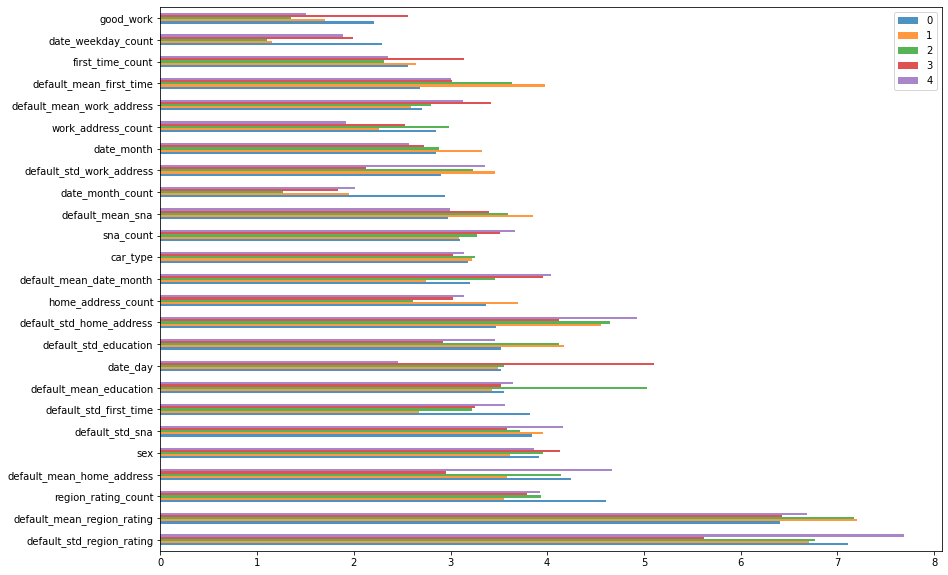

In [230]:
# Значимость признаков на разных фолдах (5 фолдов)
plot_feat_importances(feat_imp, nlargest_ = 25, figsize_ = (14, 10), only_avr = False)

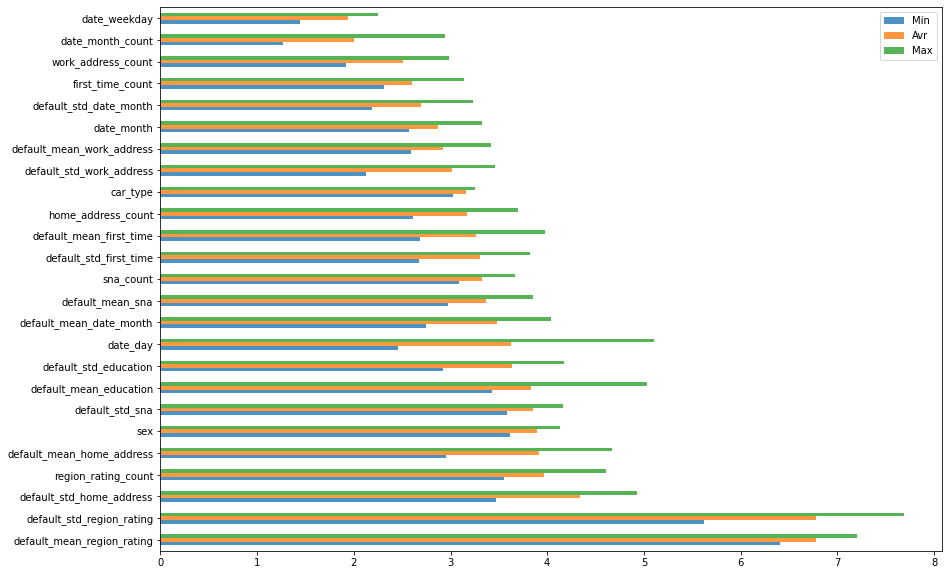

In [231]:
# Минимальная, средняя, максимальная значимость признаков с разных фолдов
plot_feat_importances(feat_imp, nlargest_ = 25, figsize_ = (14, 10), only_avr = True)

- Значимость признаков сильно варьируется в зависимости от выборки. Моделирование предпочтительнее продолжать с CV

# Генерация признаков (объединение/умножение/отношение)

In [289]:
#функции для генерации и выбора признаков на основе моделирования и расчета метрики
def new_feat_calc_mult(data, model, gen_params, split_params, fit_params, output_params, 
                       col_var, cut_off = 0.0002, delta_ = 0, k_better = 1):
    
    model_result = train_model(data, model, gen_params, split_params, fit_params, output_params)
    y_pred, y_pred_err, feat_imp, metrics_val, metrics_control = model_result
    if isinstance(metrics_val, list):
        metrics_ini = sum(metrics_val)/len(metrics_val)
    else:
        metrics_ini = metrics_val
    print("Метрика базового решения:", metrics_ini)
         
    result_an = pd.DataFrame([])
    result_an[0] = ['baseline', '--------', metrics_ini, 0]
    k = 1
    for i in range(len(col_var)):
        for j in range(i, len(col_var)):
            print(k, col_var[i], col_var[j], end = " ")
            data['temp'] = (data[col_var[i]]+delta_)*(data[col_var[j]]+delta_)
            
            model_result = train_model(data, model, gen_params, split_params, fit_params, output_params)
            y_pred, y_pred_err, feat_imp, metrics_val, metrics_control = model_result
            
            if isinstance(metrics_val, list):
                metrics_i = sum(metrics_val)/len(metrics_val)
            else:
                metrics_i = metrics_val
                      
            delta_metrics = k_better*round(metrics_i - metrics_ini, 4)           
            print(metrics_i, delta_metrics)
            result_an[k] = [col_var[i], col_var[j], metrics_i, delta_metrics]
            k +=1

    result_an.index = ['feat1', 'feat2', 'metrics', 'delta_metrics']
    result_an = result_an.T
    result_dict = result_an[result_an["delta_metrics"]>=cut_off][['feat1','feat2']].to_dict()
    
    return result_dict, result_an

In [290]:
def new_feat_calc_div(data, model, gen_params, split_params, fit_params, output_params, 
                       col_var, cut_off = 0.0002, delta_ = 0, k_better = 1):
    
    model_result = train_model(data, model, gen_params, split_params, fit_params, output_params)
    y_pred, y_pred_err, feat_imp, metrics_val, metrics_control = model_result
    if isinstance(metrics_val, list):
        metrics_ini = sum(metrics_val)/len(metrics_val)
    else:
        metrics_ini = metrics_val
    print("Метрика базового решения:", metrics_ini)
         
    result_an = pd.DataFrame([])
    result_an[0] = ['baseline', '--------', metrics_ini, 0]
    k = 1
    for i in range(len(col_var)):
        for j in range(len(col_var)):
            if i == j: continue
            print(k, col_var[i], col_var[j], end = " ")
            data['temp'] = data[col_var[i]]/(data[col_var[j]]+delta_)
            
            model_result = train_model(data, model, gen_params, split_params, fit_params, output_params)
            y_pred, y_pred_err, feat_imp, metrics_val, metrics_control = model_result
            
            if isinstance(metrics_val, list):
                metrics_i = sum(metrics_val)/len(metrics_val)
            else:
                metrics_i = metrics_val
                      
            delta_metrics = k_better*round(metrics_i - metrics_ini, 4)           
            print(metrics_i, delta_metrics)
            result_an[k] = [col_var[i], col_var[j], metrics_i, delta_metrics]
            k +=1

    result_an.index = ['feat1', 'feat2', 'metrics', 'delta_metrics']
    result_an = result_an.T
    result_dict = result_an[result_an["delta_metrics"]>=cut_off][['feat1','feat2']].to_dict()
    
    return result_dict, result_an

In [291]:
def new_feat_calc_concat(data, model, gen_params, split_params, fit_params, output_params, 
                         col_var, cut_off = 0.0002, k_better = 1):
    
    model_result = train_model(data, model, gen_params, split_params, fit_params, output_params)
    y_pred, y_pred_err, feat_imp, metrics_val, metrics_control = model_result
    if isinstance(metrics_val, list):
        metrics_ini = sum(metrics_val)/len(metrics_val)
    else:
        metrics_ini = metrics_val
    print("Метрика базового решения:", metrics_ini)
         
    result_an = pd.DataFrame([])
    result_an[0] = ['baseline', '--------', metrics_ini, 0]
    k = 1
    for i in range(len(col_var)):
        for j in range(i+1, len(col_var)):
            print(k, col_var[i], col_var[j], end = " ")
            data['temp'] = data[col_var[i]].astype(str) + "_" + data[col_var[j]].astype(str)
            agr_me(data, by = 'temp', col = 'temp', agg_func = 'count')
            data['temp'] = data['temp_count']
            
            model_result = train_model(data, model, gen_params, split_params, fit_params, output_params)
            y_pred, y_pred_err, feat_imp, metrics_val, metrics_control = model_result
            
            if isinstance(metrics_val, list):
                metrics_i = sum(metrics_val)/len(metrics_val)
            else:
                metrics_i = metrics_val
                      
            delta_metrics = k_better*round(metrics_i - metrics_ini, 4)           
            print(metrics_i, delta_metrics)
            result_an[k] = [col_var[i], col_var[j], metrics_i, delta_metrics]
            k +=1

    result_an.index = ['feat1', 'feat2', 'metrics', 'delta_metrics']
    result_an = result_an.T
    result_dict = result_an[result_an["delta_metrics"]>=cut_off][['feat1','feat2']].to_dict()
    
    return result_dict, result_an

In [275]:
split_params = {
    'random_state': RANDOM_STATE,     
    'test_size': 0.15,
    'n_splits' : 1,
    'shuffle': True,
    'stratify': "default",
}
output_params = {
    'metrics_print': False,
    'feat_importances' : False,
}

data['temp'] = 1
if 'temp' not in col_data:
    col_data.append('temp') 
gen_params = {
    'y_train_name': "default", 
    'col_data' : col_data,
    'predict_proba' : True,
    'metrics_func' : lambda x,y: round(metrics.roc_auc_score(x,y), 4),
}
model = CatBoostClassifier(**catbr_params)
col_var = ['default_std_education', 'default_mean_work_address', 'default_std_sna', 'decline_app_cnt', 
           'home_address_count', 'first_time_count', 'default_mean_education', 'default_std_home_address', 
           'default_std_first_time', 'work_address_count', 'default_std_region_rating', 'age', 'income', 
           'default_mean_first_time', 'good_work', 'score_bki']
    
result_mult, result_mult_df = new_feat_calc_mult(data, model, gen_params, split_params, fit_params, output_params, 
                                                 col_var, cut_off = 0.0002, delta_ = 5, k_better = 1)  

In [274]:
result_mult_df.head()

,feat1,feat2,metrics,delta_metrics
0,baseline,--------,0.6873,0
1,default_std_education,default_std_education,0.6888,0.0015
2,default_std_education,default_mean_work_address,0.6882,0.0009
3,default_std_education,default_std_sna,0.6887,0.0014
4,default_mean_work_address,default_mean_work_address,0.6882,0.0009


In [284]:
data['temp'] = 1
if 'temp' not in col_data:
    col_data.append('temp')
result_div, result_div_df = new_feat_calc_div(data, model, gen_params, split_params, fit_params, output_params, 
                                              col_var, cut_off = 0.0002, delta_ = 5, k_better = 1) 

In [283]:
result_div_df.head()

,feat1,feat2,metrics,delta_metrics
0,baseline,--------,0.6873,0
1,default_std_education,default_mean_work_address,0.6875,0.0002
2,default_std_education,default_std_sna,0.6887,0.0014
3,default_mean_work_address,default_std_education,0.6866,-0.0007
4,default_mean_work_address,default_std_sna,0.6877,0.0004


In [297]:
col_var = ['work_address', 'first_time', 'education', 'foreign_passport',
           'home_address', 'good_work', 'sna', 'sex', 'car_type', 'car', 'region_rating']

data['temp'] = 1
if 'temp' not in col_data:
    col_data.append('temp')
result_concat, result_concat_df = new_feat_calc_concat(data, model, gen_params, split_params, fit_params, output_params, 
                                                       col_var, cut_off = 0.0002, k_better = 1) 

In [296]:
result_concat_df.head()

,feat1,feat2,metrics,delta_metrics
0,baseline,--------,0.6873,0
1,work_address,first_time,0.6885,0.0012
2,work_address,education,0.6889,0.0016
3,work_address,foreign_passport,0.6888,0.0015
4,first_time,education,0.6873,0


In [298]:
#Расчет доп. признаков
def cross_feat(data, delta_ = 0):   
#---------------------------------Объединение-категориальных-признаков-(a_b)----------------------------------------------    
    concat = {'feat1': {25: 'car', 32: 'car_type'}, 
              'feat2': {25: 'sna', 32: 'sna'}}
    concat_df = pd.DataFrame(concat).reset_index().drop(columns = "index")
    
    dop_col_concat = []
    for i in range(concat_df.shape[0]):
        dop_col_concat.extend([concat_df.feat1[i]+"__"+concat_df.feat2[i]])   
        data[concat_df.feat1[i]+"__"+concat_df.feat2[i]] = data[concat_df.feat1[i]].astype(str) + \
                                                            "_" + data[concat_df.feat2[i]].astype(str)
        
    dop_col = []    
    for col_name_ in dop_col_concat:
        dop_col.extend(agr_me(data, by = col_name_, col = col_name_, agg_func = 'count'))
        dop_col.extend(agr_me(data, by = col_name_, col = 'default', agg_func = 'mean', agg_filtr_me = 'sample', 
                       agg_filtr_val = 1, sign = '==', Nan_obj = 0, index_str ='_'+col_name_))
        dop_col.extend(agr_me(data, by = col_name_, col = 'default', agg_func = 'std', agg_filtr_me = 'sample', 
                       agg_filtr_val = 1, sign = '==', Nan_obj = 0, index_str ='_'+col_name_))        
        
#---------------------------------Признаки на основе отношения-(a/b)-------------------------------------------------------         
    div = {'feat1': {3: 'score_bki', 12: 'score_bki', 14: 'score_bki', 17: 'score_bki', 76: 'age', 
                     398: 'default_std_first_time', 406: 'default_mean_first_time', 411: 'default_mean_first_time', 
                     425: 'default_mean_first_time', 430: 'default_mean_first_time'}, 
           'feat2': {3: 'income', 12: 'default_std_sna', 14: 'default_std_first_time', 17: 'home_address_count', 
                     76: 'work_address_count', 398: 'first_time_count', 406: 'score_bki', 411: 'decline_app_cnt', 
                     425: 'first_time_count', 430: 'good_work'}}
 
    div_df = pd.DataFrame(div).reset_index().drop(columns = "index") 
    for i in range(div_df.shape[0]):
        dop_col.extend([div_df.feat1[i]+"__D__"+div_df.feat2[i]]) 
        data[div_df.feat1[i]+"__D__"+div_df.feat2[i]] = data[div_df.feat1[i]] / (delta_+data[div_df.feat2[i]])

#----------------------------------Признаки на основе перемножения-(a*b)--------------------------------------------------
    multiply = {'feat1': {132: 'default_std_region_rating', 167: 'default_mean_education', 171: 'default_mean_education', 
                          183: 'default_std_education', 189: 'default_std_sna', 210: 'default_std_first_time', 
                          213: 'default_std_first_time', 221: 'default_mean_first_time'}, 
                'feat2': {132: 'default_mean_work_address', 167: 'default_mean_first_time', 171: 'first_time_count', 
                          183: 'first_time_count', 189: 'default_std_first_time', 210: 'default_std_home_address', 
                          213: 'first_time_count', 221: 'first_time_count'}}

    mult_df = pd.DataFrame(multiply).reset_index().drop(columns = "index")
    for i in range(mult_df.shape[0]):
        dop_col.extend([mult_df.feat1[i]+"__M__"+mult_df.feat2[i]]) 
        delta_data[mult_df.feat1[i]+"__M__"+mult_df.feat2[i]] = (delta_+data[mult_df.feat1[i]])*(delta_+data[mult_df.feat2[i]])          
        
#------------------------------------------------------------------------------------------------------------------       
    return  dop_col

col_data.extend(cross_feat(data, delta_ = 5))

In [301]:
col_data_backup = col_data.copy()
print(col_data)

['sex', 'car', 'car_type', 'foreign_passport', 'good_work', 'education_count', 'default_mean_education', 'default_std_education', 'region_rating_count', 'default_mean_region_rating', 'default_std_region_rating', 'home_address_count', 'default_mean_home_address', 'default_std_home_address', 'work_address_count', 'default_mean_work_address', 'default_std_work_address', 'sna_count', 'default_mean_sna', 'default_std_sna', 'first_time_count', 'default_mean_first_time', 'default_std_first_time', 'date_month', 'date_weekday', 'date_day', 'date_month_count', 'default_mean_date_month', 'default_std_date_month', 'date_weekday_count', 'default_mean_date_weekday', 'default_std_date_weekday', 'temp', 'car__sna_count', 'default_mean_car__sna', 'default_std_car__sna', 'car_type__sna_count', 'default_mean_car_type__sna', 'default_std_car_type__sna', 'score_bki__D__income', 'score_bki__D__default_std_sna', 'score_bki__D__default_std_first_time', 'score_bki__D__home_address_count', 'age__D__work_address

- Сгенерировано большое количество признаков, которое потенциально могут привести к улучшению метрики
- Требуется провести отбор признаков

# Отбор признаков для моделирования (алгоритм ADD DEL)

In [305]:
def add_del_algoritm(data, model, gen_params, split_params, fit_params, output_params, 
                     col_data_base, col_data_all, k_better = 1, iter_max = 300):
    
    if not col_data_base:
        col_data_base.append(col_data_all[0])
        col_data_all.remove(col_data_all[0])
        gen_params['col_data'] = col_data_base.copy()

    model_result = train_model(data, model, gen_params, split_params, fit_params, output_params)
    y_pred, y_pred_err, feat_imp, metrics_val, metrics_control = model_result

    if isinstance(metrics_val, list):
        metrics_base = sum(metrics_val)/len(metrics_val)
    else:
        metrics_base = metrics_val
    print("Метрика базового решения:", metrics_base)    
    
    k = 1 
    while k <= iter_max:
        # ADD part
        print("Starting ADD part")
        for feature_i in col_data_all.copy():
            if  k > iter_max:
                break
            
            col_data_base.append(feature_i)
            gen_params['col_data'] = col_data_base.copy()

            model_result = train_model(data, model, gen_params, split_params, fit_params, output_params)
            y_pred, y_pred_err, feat_imp, metrics_val, metrics_control = model_result
            
            if isinstance(metrics_val, list):
                metrics_i = sum(metrics_val)/len(metrics_val)
            else:
                metrics_i = metrics_val

            delta_metrics = round(k_better*(metrics_i - metrics_base),5)
            if delta_metrics > 0:
                col_data_all.remove(feature_i)
                metrics_base = metrics_i
                print(k," - ", round(metrics_i, 5)," - ", col_data_base)
            else:
                col_data_base.remove(feature_i)
                print(k," - ", round(metrics_i, 5), " -NO ADD- ", feature_i)
            k +=1

        # DEL part
        print("Starting DEL part")
        for feature_i in col_data_base.copy():
            if  k > iter_max:
                break
            
            col_data_base.remove(feature_i)
            gen_params['col_data'] = col_data_base.copy()
            
            model_result = train_model(data, model, gen_params, split_params, fit_params, output_params)
            y_pred, y_pred_err, feat_imp, metrics_val, metrics_control = model_result
            
            if isinstance(metrics_val, list):
                metrics_i = sum(metrics_val)/len(metrics_val)
            else:
                metrics_i = metrics_val
                
            delta_metrics = round(k_better*(metrics_i - metrics_base), 5)
            if delta_metrics > 0:
                col_data_all.append(feature_i)
                metrics_base = metrics_i
                print(k," - ", round(metrics_i, 5)," - ", col_data_base)
            else:
                col_data_base.append(feature_i)
                print(k," - ", round(metrics_i, 5), " -NO DEL- ", feature_i)
            k +=1
            
    return col_data_base

In [310]:
RANDOM_STATE = 900
gen_params = {
    'y_train_name': "default", 
    'col_data' : col_data,
    'predict_proba' : True,
    'metrics_func' : lambda x,y: round(metrics.roc_auc_score(x,y),4),
}
split_params = {
    'random_state': RANDOM_STATE,     
    'test_size': 0,
    'n_splits' : 4,
    'shuffle': True,
    'stratify': "default",
}
fit_params = { # для catboost
    'eval_set': True,
    'use_best_model': True,
    'plot' : False,
}
catbr_params = {
    'random_seed': RANDOM_STATE, 
    'learning_rate': 0.03, #0.03-оптимальный параметр
    'iterations': 400, #500-оптимальный параметр
    'depth': 8, # 8-оптимальный параметр
    'l2_leaf_reg': 1, # 1-оптимальный параметр
    'eval_metric': 'AUC',
    'random_strength': 0.65, #0.65-не сильно устойчивый оптимальный параметр
    'od_type': "Iter", #детектор переобучения catboost
    'od_wait': 100,   
    'verbose': False, 
}
output_params = {
    'metrics_print': False,
    'feat_importances' : False,
}

col_data_base =  []
col_data_all = ['sex', 'car', 'car_type', 'foreign_passport', 'good_work', 'education_count', 'default_mean_education', 
                'default_std_education', 'region_rating_count', 'default_mean_region_rating', 'default_std_region_rating', 
                'home_address_count', 'default_mean_home_address', 'default_std_home_address', 'work_address_count', 
                'default_mean_work_address', 'default_std_work_address', 'sna_count', 'default_mean_sna', 'default_std_sna', 
                'first_time_count', 'default_mean_first_time', 'default_std_first_time', 'date_month', 'date_weekday', 
                'date_day', 'date_month_count', 'default_mean_date_month', 'default_std_date_month', 'date_weekday_count', 
                'default_mean_date_weekday', 'default_std_date_weekday', 'temp', 'car__sna_count', 'default_mean_car__sna', 
                'default_std_car__sna', 'car_type__sna_count', 'default_mean_car_type__sna', 'default_std_car_type__sna', 
                'score_bki__D__income', 'score_bki__D__default_std_sna', 'score_bki__D__default_std_first_time', 
                'score_bki__D__home_address_count', 'age__D__work_address_count', 'default_std_first_time__D__first_time_count',
                'default_mean_first_time__D__score_bki', 'default_mean_first_time__D__decline_app_cnt', 
                'default_mean_first_time__D__first_time_count', 'default_mean_first_time__D__good_work', 
                'default_std_region_rating__M__default_mean_work_address', 'default_mean_education__M__default_mean_first_time',
                'default_mean_education__M__first_time_count', 'default_std_education__M__first_time_count', 
                'default_std_sna__M__default_std_first_time', 'default_std_first_time__M__default_std_home_address', 
                'default_std_first_time__M__first_time_count', 'default_mean_first_time__M__first_time_count']
col_data_all_backup = col_data_all.copy()

model = CatBoostClassifier(**catbr_params)
col_data_fin = add_del_algoritm(data, model, gen_params, split_params, fit_params, output_params, 
                                col_data_base, col_data_all, k_better = 1, iter_max = 250)

In [312]:
print(col_data_fin)

['data_ind', 'sex', 'car', 'car_type', 'foreign_passport', 'good_work', 'age', 'decline_app_cnt', 'bki_request_cnt', 'income', 'education_count', 'default_mean_education', 'region_rating_count', 'default_mean_region_rating', 'home_address_count', 'work_address_count', 'default_mean_work_address', 'sna_count', 'default_mean_sna', 'first_time_count', 'default_mean_first_time', 'default_std_first_time', 'score_bki__D__income', 'default_std_education', 'date_day', 'date_month_count', 'default_std_date_month', 'date_weekday_count', 'default_mean_date_weekday']


- Найден перечень признаков для моделирования в рамках алгоритма ADD_DEL 

# Финальное моделирование

In [386]:
#---------------------------ОБУЧЕНИЕ-----CatBoostClassifier---CV-------------------------------------------------------
RANDOM_STATE = 900
col_data = ['sex', 'car', 'car_type', 'foreign_passport', 'good_work', 'age', 'decline_app_cnt', 
            'bki_request_cnt', 'income', 'education_count', 'default_mean_education', 'region_rating_count', 
            'default_mean_region_rating', 'home_address_count', 'work_address_count', 'default_mean_work_address', 
            'sna_count', 'default_mean_sna', 'first_time_count', 'default_mean_first_time', 'default_std_first_time', 
            'score_bki__D__income', 'default_std_education', 'date_day', 'date_month_count', 'default_std_date_month', 
            'date_weekday_count', 'default_mean_date_weekday'] 
gen_params = {
    'y_train_name': "default", 
    'col_data' : col_data,
    'predict_proba' : True,
    'metrics_func' : lambda x,y: round(metrics.roc_auc_score(x,y),4),
}
split_params = {
    'random_state': RANDOM_STATE,     
    'test_size': 0,
    'n_splits' : 5,
    'shuffle': True,
    'stratify': "default",
}
fit_params = { # для catboost
    'eval_set': True,
    'use_best_model': True,
    'plot' : False,
}
catbr_params = {
    'random_seed': RANDOM_STATE, 
    'learning_rate': 0.03, #0.03-оптимальный параметр
    'iterations': 500, #500-оптимальный параметр
    'depth': 8, # 8-оптимальный параметр
    'l2_leaf_reg': 1, # 1-оптимальный параметр
    'eval_metric': 'AUC',
    'random_strength': 0.65, #0.65-не сильно устойчивый оптимальный параметр
    'od_type': "Iter", #детектор переобучения catboost
    'od_wait': 150,   
    'verbose': False, 
}
output_params = {
    'metrics_print': True,
    'feat_importances' : False,
}

i = 1
for _ in range(10):
    catbr_params['random_seed'] = random.randint(1, 10000)
    split_params['random_state'] = random.randint(1, 10000)
    catbr_params['l2_leaf_reg'] = random.choice([0.994, 0.996, 0.998, 1, 1.002, 1.004, 1.006])
    catbr_params['random_strength'] = random.choice([0.646, 0.647, 0.648, 0.649, 0.65, 0.651, 0.652, 0.653, 0.653])
    print("№"+str(i)+": ", end = "")
    
    model = CatBoostClassifier(**catbr_params)
    model_result = train_model(data, model, gen_params, split_params, fit_params, output_params)
    y_pred, y_pred_err, feat_imp, metrics_val, metrics_control = model_result  
    data['result_new_v_' + str(i)] = sum(y_pred)/len(y_pred)
    i += 1

№1: Метрики фолдов: 0 - 0.7334, 1 - 0.7392, 2 - 0.7433, 3 - 0.7378, 4 - 0.7356  Ср.зн.: 0.73786
№2: Метрики фолдов: 0 - 0.7442, 1 - 0.7451, 2 - 0.7287, 3 - 0.7374, 4 - 0.7371  Ср.зн.: 0.7385
№3: Метрики фолдов: 0 - 0.7478, 1 - 0.7277, 2 - 0.7403, 3 - 0.7377, 4 - 0.7389  Ср.зн.: 0.73848
№4: Метрики фолдов: 0 - 0.7306, 1 - 0.7521, 2 - 0.7323, 3 - 0.7327, 4 - 0.7457  Ср.зн.: 0.73868
№5: Метрики фолдов: 0 - 0.7434, 1 - 0.7367, 2 - 0.7418, 3 - 0.731, 4 - 0.7402  Ср.зн.: 0.73862
№6: Метрики фолдов: 0 - 0.7397, 1 - 0.7441, 2 - 0.743, 3 - 0.7311, 4 - 0.7375  Ср.зн.: 0.73908
№7: Метрики фолдов: 0 - 0.7349, 1 - 0.7415, 2 - 0.7429, 3 - 0.7353, 4 - 0.7376  Ср.зн.: 0.73844
№8: Метрики фолдов: 0 - 0.7384, 1 - 0.7468, 2 - 0.73, 3 - 0.7459, 4 - 0.7341  Ср.зн.: 0.73904
№9: Метрики фолдов: 0 - 0.7422, 1 - 0.7408, 2 - 0.7361, 3 - 0.7304, 4 - 0.7403  Ср.зн.: 0.73796
№10: Метрики фолдов: 0 - 0.736, 1 - 0.7421, 2 - 0.7311, 3 - 0.7478, 4 - 0.7396  Ср.зн.: 0.73932


In [391]:
col_list = filtr_list_all(data.columns, ['result_new_v_'], include = True)
data['y_pred_v0'] = data[col_list].mean(axis = 1)
submission_to_csv(data, y_res_name = 'y_pred_v0', sub_file = 'submission.csv')
save_func(data, col_data = col_data, filename = 'data_fin.zip', colname = "columns.json")

       client_id   default
73799      74835  0.035615
73800      17527  0.244180
73801      75683  0.076548


# Оптимизация итогового решения

In [394]:
# Нахождение неотрицательных коэф. (задача с ограничениями) на усреднение решений при помощи гребневой регрессии 
def ridge_error(x_train_, y_train_, w, alpha):
    err = y_train_ - x_train_@w
    return err.T@err + alpha*w.T@w


def find_alpha_in_ridge(data, col_list, col_y, metrics, alpha_list,  bound_coef = 2, n_splits = 5, round_dig = 8):
    y_train = data[data['sample'] == 1][col_y]
    x_train = data[data['sample'] == 1][col_list]
    method = 'SLSQP' 
    w_ini = np.zeros(len(col_list))
    w_bounds = tuple(zip(np.zeros(len(col_list)), bound_coef*np.ones(len(col_list))/len(col_list)))
    kf = KFold(random_state = 323, n_splits = n_splits, shuffle = True)
    
    metric_train_list = np.zeros((len(alpha_list), n_splits))
    metric_test_list = np.zeros((len(alpha_list), n_splits))
    k_alpha = 0
    for alpha in alpha_list:
        k_cv = 0
        for cv_train_index, cv_test_index in kf.split(x_train.values, y_train.values):
            cv_x_train, cv_x_test = x_train.values[cv_train_index], x_train.values[cv_test_index]
            cv_y_train, cv_y_test = y_train.values[cv_train_index], y_train.values[cv_test_index]

            opt_res = optimize.minimize(lambda w: ridge_error(cv_x_train, cv_y_train, w, alpha), 
                                        w_ini, bounds = w_bounds, method = method, tol = 1e-10)
            w_res = opt_res.x.copy()
            cv_y_pred_test = cv_x_test@w_res
            cv_y_pred_train = cv_x_train@w_res
            metric_train_list[k_alpha, k_cv] = metrics_(cv_y_train, cv_y_pred_train)
            metric_test_list[k_alpha, k_cv] = metrics_(cv_y_test, cv_y_pred_test)        
            k_cv += 1  
            
        print("Alpha:", alpha, "Cр.зн. фолдов: {}".format(round(metric_test_list[k_alpha,:].mean(), round_dig)))       
        k_alpha += 1

In [400]:
col_list = filtr_list_all(data.columns, ['result_new_v_'], include = True)
alpha_list = [round(3 + i, 4) for i in range(0, 41, 1)]
metrics_ = metrics.roc_auc_score

find_alpha_in_ridge(data, col_list, 'default', metrics_, alpha_list)

Alpha: 3 Cр.зн. фолдов: 0.79026886
Alpha: 4 Cр.зн. фолдов: 0.79026908
Alpha: 5 Cр.зн. фолдов: 0.79026934
Alpha: 6 Cр.зн. фолдов: 0.79026952
Alpha: 7 Cр.зн. фолдов: 0.79026977
Alpha: 8 Cр.зн. фолдов: 0.79026997
Alpha: 9 Cр.зн. фолдов: 0.7902701
Alpha: 10 Cр.зн. фолдов: 0.79027018
Alpha: 11 Cр.зн. фолдов: 0.79027034
Alpha: 12 Cр.зн. фолдов: 0.79027057
Alpha: 13 Cр.зн. фолдов: 0.79027077
Alpha: 14 Cр.зн. фолдов: 0.79027082
Alpha: 15 Cр.зн. фолдов: 0.79027096
Alpha: 16 Cр.зн. фолдов: 0.79027105
Alpha: 17 Cр.зн. фолдов: 0.79027127
Alpha: 18 Cр.зн. фолдов: 0.7902714
Alpha: 19 Cр.зн. фолдов: 0.79027162
Alpha: 20 Cр.зн. фолдов: 0.79027164
Alpha: 21 Cр.зн. фолдов: 0.79027111
Alpha: 22 Cр.зн. фолдов: 0.79026982
Alpha: 23 Cр.зн. фолдов: 0.79026782
Alpha: 24 Cр.зн. фолдов: 0.79026623
Alpha: 25 Cр.зн. фолдов: 0.79026482
Alpha: 26 Cр.зн. фолдов: 0.79026378
Alpha: 27 Cр.зн. фолдов: 0.79026282
Alpha: 28 Cр.зн. фолдов: 0.79026129
Alpha: 29 Cр.зн. фолдов: 0.79026055
Alpha: 30 Cр.зн. фолдов: 0.79025899
A

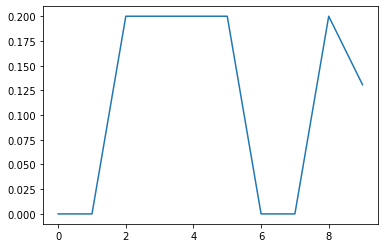

In [401]:
alpha = 21
y_train = data[data['sample'] == 1]['default']
x_train = data[data['sample'] == 1][col_list]
bound_coef = 2
w_ini = np.zeros(len(col_list))
w_bounds = tuple(zip(np.zeros(len(col_list)), bound_coef*np.ones(len(col_list))/len(col_list)))
opt_res = optimize.minimize(lambda w: ridge_error(x_train, y_train, w, alpha), 
                            w_ini, bounds = w_bounds, method = 'SLSQP',tol = 1e-20)
w_res = opt_res.x
data['y_pred_v0_myridge'] = data[col_list]@w_res
# print(alpha, metrics.roc_auc_score(y_train, data[data['sample'] == 1]['y_pred_v0_myridge']))
plt.plot(w_res);

In [402]:
submission_to_csv(data, y_res_name = 'y_pred_v0_myridge', sub_file = 'submission.csv')
save_func(data, col_data = col_data, filename = 'data_fin.zip', colname = "columns.json")
metrics.roc_auc_score(data[data['sample'] == 1]['default'], data[data['sample'] == 1]['y_pred_v0_myridge'])

       client_id   default
73799      74835  0.040114
73800      17527  0.276757
73801      75683  0.085785


0.7902550144578298

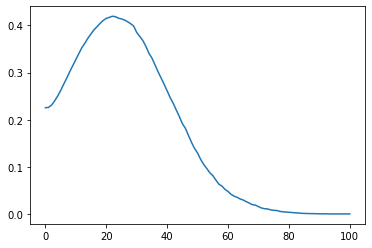

In [407]:
f1_score_list = []
for i in range(101):
    m = metrics.f1_score(data[data['sample'] == 1]['default'], data[data['sample'] == 1]['y_pred_v0_myridge'] > i/100)
    f1_score_list.append(m)
    
plt.plot(f1_score_list);

In [411]:
crit = (np.array(f1_score_list).argmax()+1)/100
metrics.confusion_matrix(data[data['sample'] == 1]['default'], data[data['sample'] == 1]['y_pred_v0_myridge'] > crit)

array([[56054,  8373],
       [ 4676,  4696]], dtype=int64)

- Модель имеет высокие ошибки 1 и 2 рода
- Применимость модели зависисть от бизнес метрик